In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')


from utils import scatter_plot
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [2]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [4]:
X_train['drain_area_va'] = np.log10(X_train['drain_area_va'])
X_train['q_va'] = np.log10(X_train['q_va'])
X_train['stream_wdth_va'] = np.log10(X_train['stream_wdth_va'])
X_train['xsec_area_va'] = np.log10(X_train['xsec_area_va'])
y_train= np.log10(y_train)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test['drain_area_va'] = np.log10(X_test['drain_area_va'])
X_test['q_va'] = np.log10(X_test['q_va'])
X_test['stream_wdth_va'] = np.log10(X_test['stream_wdth_va'])
X_test['xsec_area_va'] = np.log10(X_test['xsec_area_va'])

X_test = X_scaler.transform(X_test).astype('float32')

In [5]:
## Model
svr = SVR()
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
              'kernel': ['rbf']}

svr_grid = GridSearchCV(svr, param_grid, cv=8, n_jobs=30, verbose=3)
svr_grid.fit(X_train, y_train)

Fitting 8 folds for each of 32 candidates, totalling 256 fits


GridSearchCV(cv=8, estimator=SVR(), n_jobs=30,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6,
                                   0.9],
                         'kernel': ['rbf']},
             verbose=3)

In [6]:
print(svr_grid.best_params_)
print(svr_grid.best_score_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9965509970137536


In [11]:
import pickle

with open('./data/ml_weights/svr_best_model', "wb") as fp:
    pickle.dump(svr_grid.best_estimator_, fp)

In [5]:
import pickle

with open('./data/ml_weights/svr_best_model', "rb") as fp:
    svr_grid = pickle.load(fp)

NSE: 0.9858, R2: 0.9861, PBias: 0.5349, MSE: 0.7355


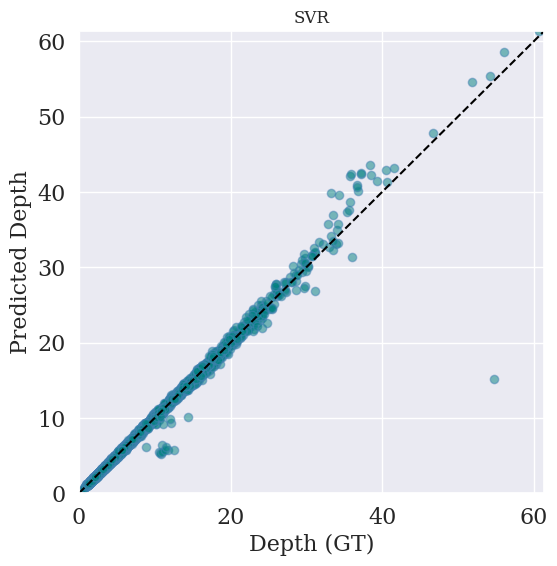

In [7]:
y_pred = svr_grid.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_pred = 10 ** y_pred
scatter_plot(y_test, y_pred, model_name='SVR')

In [8]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(svr_grid, X_train, y_train, n_repeats=10, random_state=42, n_jobs=30)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

index=['drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va']
svr_importances = pd.Series(result.importances_mean, index=index)

Elapsed time to compute the importances: 3.016 seconds


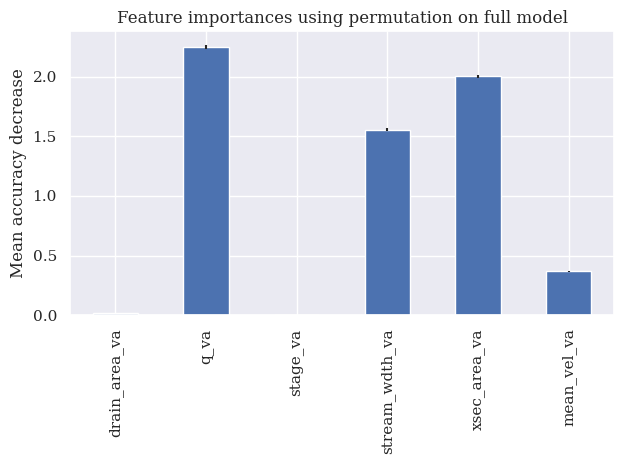

In [9]:
fig, ax = plt.subplots()
svr_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()